In [57]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [2]:
config = load_config("../config.yaml")

In [3]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 8:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
        batch_size = int(model_name[6])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
        batch_size = int(model_name[5])
    return model_type, activation, hidden_size, learning_rate, batch_size

parse_model_info('leaky_gru_leaky_relu_128_0.001_128_train.pth')



('leaky_gru', 'leaky_relu', 128, 0.001, 128)

In [4]:
def get_dynamics_model(rnn_type, activation, hidden_size, lr, model, group,device, n_components=3):
    # Load configuration and set hyperparameters
    config = load_config("../config.yaml")
    ruleset = config["rules_analysis"][-1]
    all_rules = config["rules_analysis"]

    hp = {
        "rnn_type": rnn_type,
        "activation": activation,
        "n_rnn": hidden_size,
        "learning_rate": lr,
        "l2_h": 0.00001,
        "l2_weight": 0.00001,
        "mode": "test",
    }
    hp, _, _ = main.set_hyperparameters(
        model_dir="debug", hp=hp, ruleset=all_rules, rule_trains=ruleset
    )
    run_model = main.load_model(
        f"../models/{group}/{model}",
        hp,
        RNNLayer,
        device=device,
    )
    h = main.representation(run_model, all_rules)
    h_trans, explained_variance = main.compute_pca(h, n_components=n_components)
    tensor_on_cpu = h_trans[("AntiPerceptualDecisionMakingDelayResponseT", "stimulus")].cpu()
    return tensor_on_cpu.detach().numpy(), explained_variance

### Get dynamics to plot

In [120]:
model = "leaky_rnn_softplus_256_0.001_128_train.pth"

#### Pretrain unfrozen

In [121]:
group = "pretrain_unfrozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_model(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

FileNotFoundError: [Errno 2] No such file or directory: '../models/pretrain_unfrozen/leaky_rnn_softplus_256_0.001_128_train.pth'

#### Visualize the curves

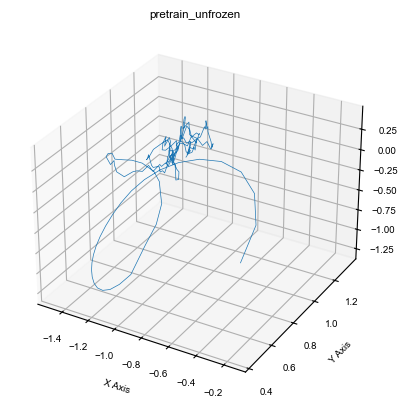

In [122]:
visualize([curve[:,100,:]],title=group)

#### Pretrain frozen

In [123]:
group = "pretrain_frozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_model(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

FileNotFoundError: [Errno 2] No such file or directory: '../models/pretrain_frozen/leaky_rnn_softplus_256_0.001_128_train.pth'

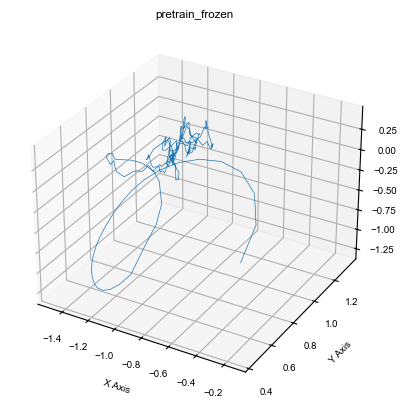

In [124]:
visualize([curve[:,100,:]],title=group)

#### master

In [118]:
group = "master"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_model(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

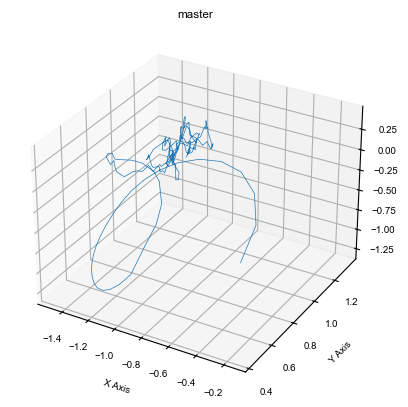

In [119]:
visualize([curve[:,100,:]],title=group)

### Get dissimilarities

#### Computation dynamics

In [35]:
# load data
path = "../data/dissimilarities"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        data.append(df)
data = pd.concat(data)

# Create a new DataFrame with swapped values
df_swapped = data.rename(columns={"model1": "model2", "model2": "model1", "group1": "group2", "group2": "group1"})

# Concatenate the original DataFrame with the swapped DataFrame
data = pd.concat([data, df_swapped], ignore_index=True)

data_groupes_mean_dissimilarity = data.groupby(['group1', 'group2'])[["cka","procrustes","dsa"]].median().reset_index()
data_models = data[data['model1'] == data['model2']].groupby(['group1', 'group2','model1','model2'])[["cka","procrustes","dsa"]].median().reset_index()
data_models_averaged = data_models.groupby(['group1', 'group2'])[["cka","procrustes","dsa"]].median().reset_index()

##### Dissimilarities Many to Many models

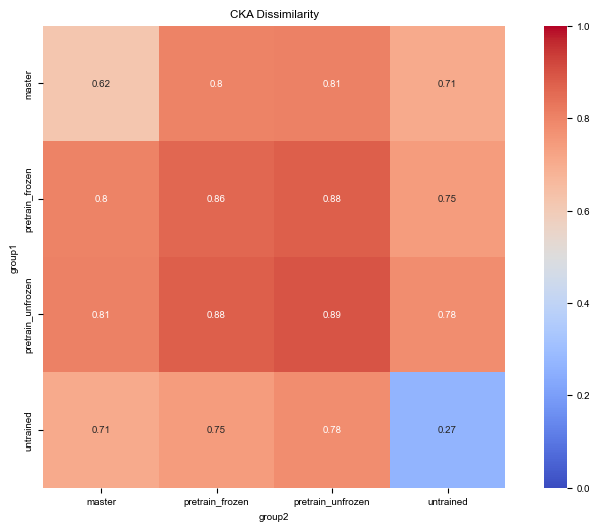

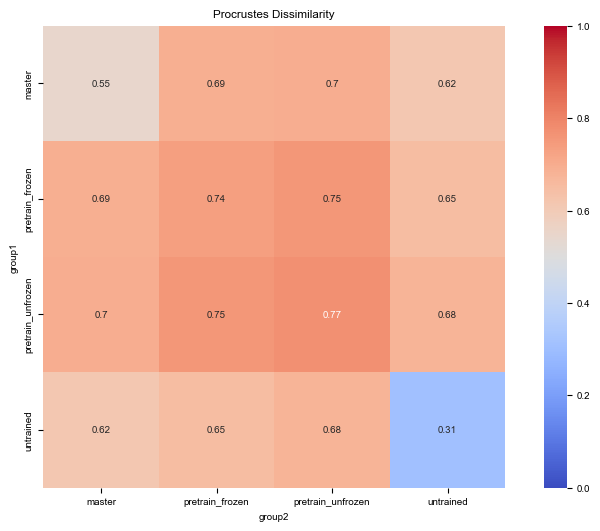

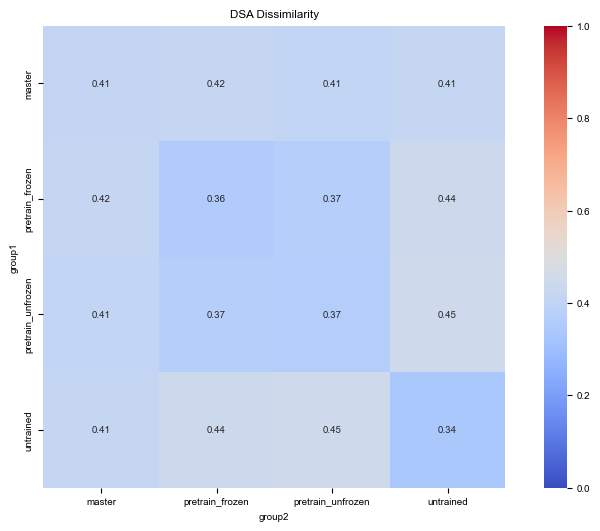

In [36]:
# plot heatmap of the dissimilarity between the groups
df = pd.DataFrame(data_groupes_mean_dissimilarity)

# Pivot the dataframe to prepare for heatmap
pivot_df = df.pivot(index='group1', columns='group2', values=['cka', 'procrustes', 'dsa'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['cka'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('CKA Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['procrustes'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('Procrustes Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['dsa'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('DSA Dissimilarity')
plt.show()

##### Dissimilarities One to One models

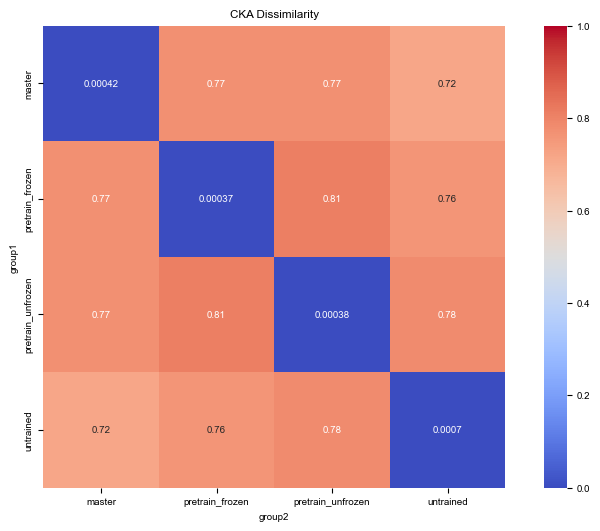

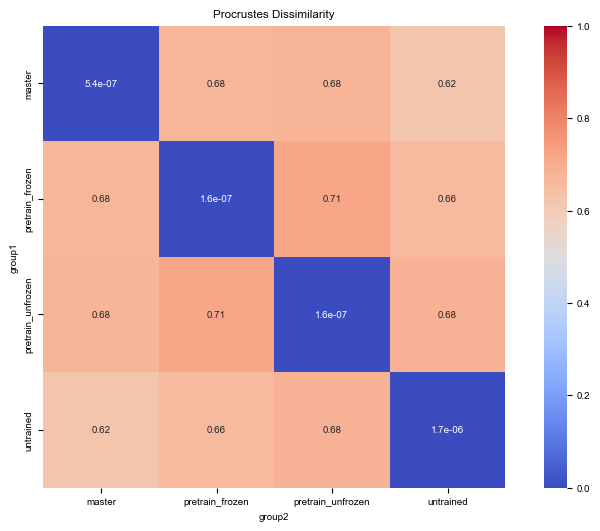

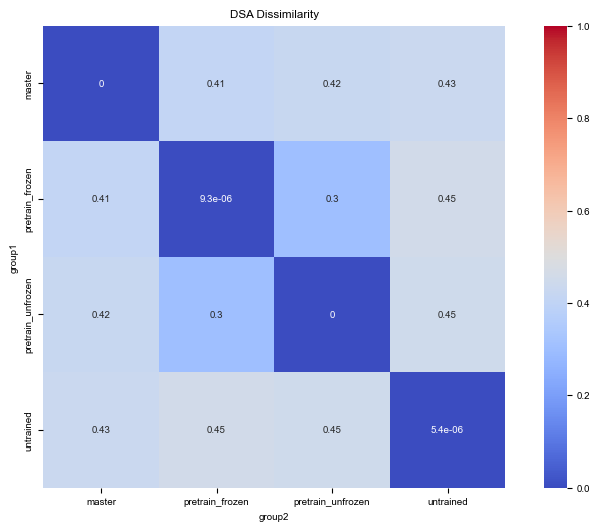

In [21]:
# plot heatmap of the dissimilarity between the groups
df = pd.DataFrame(data_models_averaged)

# Pivot the dataframe to prepare for heatmap
pivot_df = df.pivot(index='group1', columns='group2', values=['cka', 'procrustes', 'dsa'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['cka'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('CKA Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['procrustes'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('Procrustes Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['dsa'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('DSA Dissimilarity')
plt.show()

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [82]:
path = "../data/dissimilarities_over_learning"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        data.append(df)
df = pd.concat(data)
df['cka'] = df['cka'].apply(ast.literal_eval)
df['procrustes'] = df['procrustes'].apply(ast.literal_eval)
df['dsa'] = df['dsa'].apply(ast.literal_eval)
# Create a new DataFrame with swapped values
df_swapped = df.rename(columns={"group1": "group2", "group2": "group1"})

# Concatenate the original DataFrame with the swapped DataFrame
df = pd.concat([df, df_swapped], ignore_index=True)

In [83]:
df

,group1,group2,rnn_type,activation,hidden_size,lr,batch_size,cka,procrustes,dsa
0,pretrain_frozen,pretrain_unfrozen,leaky_rnn,leaky_relu,128,0.0001,128,"[0.8451466961654882, 0.8714011619642832, 0.864...","[0.7058575336682896, 0.7236603450954888, 0.714...","[0.22595158219337463, 0.43611133098602295, 0.2..."
1,pretrain_frozen,pretrain_unfrozen,leaky_rnn,leaky_relu,128,0.0001,256,"[0.8378818591452334, 0.8777510846037959, 0.872...","[0.6822152331986625, 0.7275498251454788, 0.714...","[0.22434218227863312, 0.21072784066200256, 0.2..."
2,pretrain_frozen,pretrain_unfrozen,leaky_rnn,leaky_relu,128,0.0010,128,[],[],[]
3,pretrain_frozen,pretrain_unfrozen,leaky_rnn,leaky_relu,128,0.0010,256,"[0.8132926165090718, 0.804532075647832, 0.8069...","[0.7090301865111027, 0.699208725553603, 0.6974...","[0.3284929394721985, 0.3411642611026764, 0.354..."
4,pretrain_frozen,pretrain_unfrozen,leaky_rnn,leaky_relu,256,0.0001,128,"[0.7471542385833564, 0.7246770811420605, 0.733...","[0.7014299535247396, 0.6818487022417522, 0.689...","[0.27560898661613464, 0.2775292694568634, 0.34..."
...,...,...,...,...,...,...,...,...,...,...
379,master,pretrain_unfrozen,leaky_gru,tanh,128,0.0010,256,"[0.8144038599306266, 0.8104365531217644, 0.806...","[0.6886555994885046, 0.6852038571650438, 0.667...","[0.36152446269989014, 0.39594388008117676, 0.3..."
380,master,pretrain_unfrozen,leaky_gru,tanh,256,0.0001,128,"[0.7179207575787663, 0.7633506144169632, 0.752...","[0.6526854603786953, 0.6669303114590708, 0.667...","[0.4856291115283966, 0.5937867760658264, 0.433..."
381,master,pretrain_unfrozen,leaky_gru,tanh,256,0.0001,256,"[0.8228167127779171, 0.7965168552382882, 0.801...","[0.7195054904121576, 0.697806991397944, 0.6990...","[0.4435030519962311, 0.5354588627815247, 0.357..."
382,master,pretrain_unfrozen,leaky_gru,tanh,256,0.0010,128,"[0.7068387000149235, 0.7159332292901637]","[0.645812707497645, 0.6459659553898592]","[0.40444621443748474, 0.2911059260368347]"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.9012040330461561, 0.9014046092079407, 0.8795272270943564]
[0.0, 33.33333333333333, 66.66666666666666]


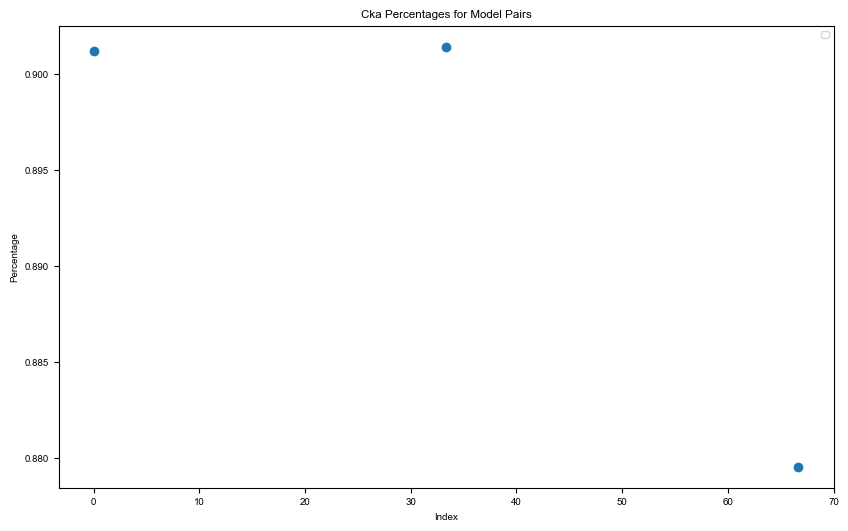

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.8024396366816469, 0.7926398402373246, 0.7652590365692066]
[0.0, 33.33333333333333, 66.66666666666666]


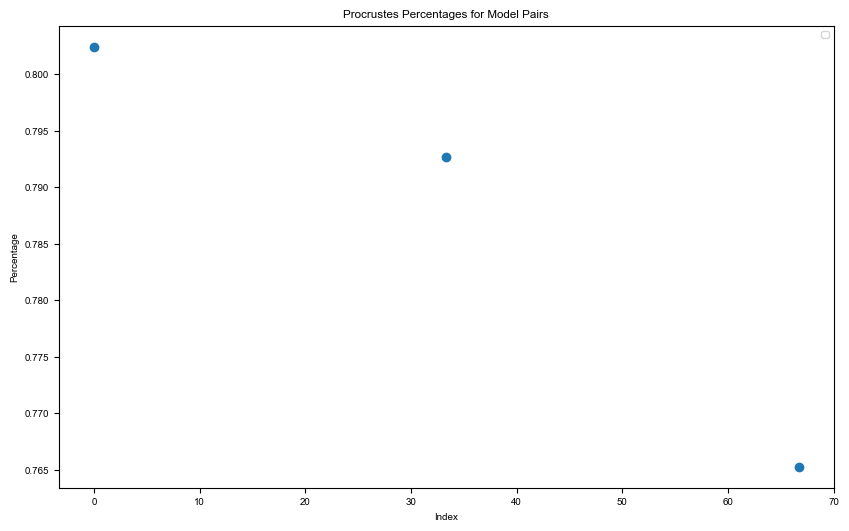

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.35432368516921997, 0.3301865756511688, 0.3018403649330139]
[0.0, 33.33333333333333, 66.66666666666666]


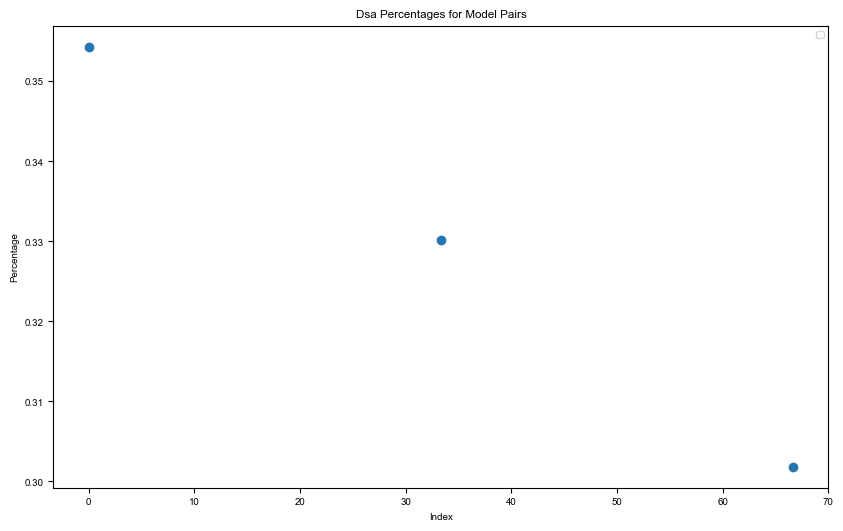

In [88]:
# Fix group1 and group2
group1_fixed = "pretrain_frozen"
group2_fixed = "pretrain_unfrozen"
rnn_type = "leaky_rnn"
activation = "relu"
hidden_size = 256
learning_rate = 0.001
batch_size = 128

df_filtered = df[(df['group1'] == group1_fixed) & (df['group2'] == group2_fixed) & (df['rnn_type'] == rnn_type) & (df['activation'] == activation) & (df['hidden_size'] == hidden_size) & (df['lr'] == learning_rate) & (df['batch_size'] == batch_size)]

# Plotting
def plot_measure(measure):
    plt.figure(figsize=(10, 6))
    
    for index, row in df_filtered.iterrows():
        values = row[measure]
        print(values)
        percentages = [(index / len(values)) * 100 for index in range(len(values))]
        print(percentages)
        plt.scatter(percentages, values)
    
    plt.title(f'{measure.capitalize()} Percentages for Model Pairs')
    plt.xlabel('Index')
    plt.ylabel('Percentage')
    plt.legend()
    plt.show()

# Plotting for cka, procrustes, and dsa
plot_measure('cka')
plot_measure('procrustes')
plot_measure('dsa')